In [1]:
import pickle
import os

import numpy as np
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from dataset.dataset import load_data
from dataset.utils import *
import matplotlib.pyplot as plt

from models.vgg import *
from models.converter import convert
import lrp
import torchexplain

torch.set_printoptions(sci_mode=False)

In [2]:
# Joint Model
def ModelXtoCtoY(n_class_attr, pretrained, freeze, num_classes, n_attributes, expand_dim, use_relu, use_sigmoid, train=True, **kwargs):
	vgg_model = vgg16_bn(pretrained=pretrained, num_classes=num_classes, n_attributes=n_attributes, bottleneck=True, expand_dim=expand_dim, train=train, **kwargs)
	model1 = x_to_c_model(freeze=freeze, model=vgg_model)
	if n_class_attr == 3:
		model2 = MLP(input_dim=n_attributes * n_class_attr, num_classes=num_classes, expand_dim=expand_dim, train=train)
	else:
		model2 = MLP(input_dim=n_attributes, num_classes=num_classes, expand_dim=expand_dim, train=train)
	return End2EndModel(model1, model2, use_relu, use_sigmoid, n_class_attr)

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    print("Device:", device, torch.cuda.get_device_name(0))
else:
    print("Device:", device)

Device: cuda:0 NVIDIA GeForce GTX 1650 Ti


In [4]:
def register_hooks(layer, in_, grad_, name):
	def get_in(self, l_in, l_out):
		in_[name] = l_in[0]

	def get_grad(self, grad_in, grad_out):
		grad_[name] = grad_in[0]
	fwd = layer.register_forward_hook(get_in)
	bkd = layer.register_full_backward_hook(get_grad)
	return fwd, bkd


def remove_hooks(hooks):
	for i in hooks:
		i.remove()

In [5]:
##### https://github.com/fhvilshoj/TorchLRP/blob/74253a1be05f0be0b7c535736023408670443b6e/examples/visualization.py#L60
def heatmap(X, cmap_name="seismic"):
    cmap = plt.cm.get_cmap(cmap_name)
    
    if len(X.shape) == 2:  # Input tensor is a 1xn vector, add 
        X = X.unsqueeze(1)

    if X.shape[1] in [1, 3]:  # move channel index to end + convert to np array
        if len(X.shape) == 3:
            X = X.permute(0, 2, 1).detach().cpu().numpy()
        else:
            X = X.permute(0, 2, 3, 1).detach().cpu().numpy()
    if isinstance(X, torch.Tensor):  # convert tensor to np array
        X = X.detach().cpu().numpy()

    shape = X.shape
    tmp = X.sum(axis=-1) # Reduce channel axis

    tmp = project(tmp, output_range=(0, 255)).astype(int)
    tmp = cmap(tmp.flatten())[:, :3].T
    tmp = tmp.T

    shape = list(shape)
    shape[-1] = 3
    return tmp.reshape(shape).astype(np.float32)

def project(X, output_range=(0, 1)):
    absmax = np.abs(X).max(axis=tuple(range(1, len(X.shape))), keepdims=True)
    X /= absmax + (absmax == 0).astype(float)
    X = (X+1) / 2. # range [0, 1]
    X = output_range[0] + X * (output_range[1] - output_range[0]) # range [x, y]
    return X

Select varables for model

**Sequential**  
use_sigmoid = False

**Independent**  
use_sigmoid = True

**Join without sig**  
use_sigmoid = False

**Joint with sig**  
use_sigmoid = True

In [6]:
use_relu = False
use_sigmoid = False
freeze = False
expand_dim = 0
pretrained = False
train = True
n_class_attr = 2

In [18]:
# CBM dataset split and model (112 class level concpts)

N_CONCEPT = 112

val_split = pickle.load(open("./dataset/CUB/dataset_splits/CBM_dataset_split/test.pkl", "rb"))
val_loader = load_data("./dataset/CUB/dataset_splits/CBM_dataset_split/train.pkl", 16, image_dir='dataset/CUB/data/images', return_orig=True)

class_index_to_string = IndexToString("./dataset/CUB/data/classes.txt", classes=True)
concept_index_to_string = IndexToString("./dataset/CUB/dataset_splits/CBM_dataset_split/attributes.txt")

XtoCtoY_model = ModelXtoCtoY(n_class_attr=n_class_attr, pretrained=pretrained, num_classes=200, n_attributes=112, expand_dim=expand_dim, freeze=freeze, use_relu=use_relu, use_sigmoid=use_sigmoid, train=train)
XtoCtoY_model.load_state_dict(torch.load("./models/state_dict/sequential_seed1.pth"))
XtoCtoY_model.to(device)
XtoCtoY_model.eval()

print("model loaded")

model loaded


In [19]:
CtoY_model = MLP(N_CONCEPT, 200, expand_dim=expand_dim, train=False).to(device)
CtoY_model.load_state_dict(XtoCtoY_model.sec_model.state_dict())

print(CtoY_model)

Using torchexplain
MLP(
  (linear): Linear(in_features=112, out_features=200, bias=True)
)


## Show true concepts and classification + predicted concepts and classification

True image size (channels, width, height): torch.Size([3, 299, 299])
True  image label: Field_Sparrow
True  image concepts: tensor([0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0.,
        0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0.,
        1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 1., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.,
        0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1.,
        0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])


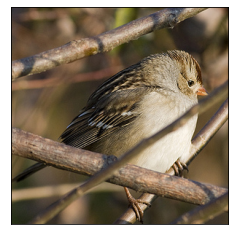

Predicted image label: Field_Sparrow
Predicted concepts: tensor([[    0.0000,     0.0000,     0.0005,     0.9997,     0.9999,     0.0001,
             0.0000,     0.0004,     0.0000,     0.9999,     0.9995,     0.0001,
             0.0000,     0.0049,     0.0000,     0.9999,     0.0000,     0.0000,
             0.0000,     0.0000,     0.0005,     1.0000,     0.9977,     0.0000,
             0.0000,     0.9988,     0.0001,     0.0000,     0.0001,     0.0000,
             0.9993,     0.9994,     0.0000,     0.0000,     0.0006,     0.0000,
             1.0000,     0.0000,     0.0000,     0.0000,     0.0000,     0.0000,
             0.0000,     0.0013,     1.0000,     0.0000,     0.0000,     0.0000,
             0.0003,     1.0000,     0.9989,     0.0000,     0.9999,     0.0000,
             0.0000,     0.0000,     0.0000,     0.0010,     0.0000,     0.0000,
             0.0000,     0.0000,     0.0000,     1.0000,     0.0000,     0.0003,
             0.0000,     0.0000,     0.0001,     0.9

In [20]:
imageId = 10

images, labels, concepts, original_imgs = next(iter(val_loader))
image, label = images[imageId].to(device), labels[imageId].to(device)

# print / show input
print("True image size (channels, width, height):", image.size())
print("True  image label:", class_index_to_string(label.item()))
print("True  image concepts:", concepts[imageId])

plt.xticks([])
plt.yticks([])
plt.imshow(original_imgs[imageId].squeeze().permute(1, 2, 0))
plt.show()


image = image.unsqueeze(0)
image.requires_grad_(True)
image.grad = None

# get model prediction and LRP map for classification
prediction = XtoCtoY_model(image)
_, pred = torch.max(prediction[0], 1)

print("Predicted image label:", class_index_to_string(pred.item()))
pred_concepts_readable = torch.nn.Sigmoid()(prediction[1])
print("Predicted concepts:", pred_concepts_readable)

# print concept as string if prediction is >= 0.5
for idx, i in enumerate(pred_concepts_readable[0]):
    if i.item() >= 0.5:
        print(idx + 1, concept_index_to_string(idx), i.item())

## generate C to Y concept vector saliency map

In [21]:
image, label = images[imageId].to(device), labels[imageId].to(device)
#image, label = images.to(device), labels.to(device)
image = image.unsqueeze(0)
image.requires_grad_(True)
image.grad = None  # Reset gradient

pred_concepts = XtoCtoY_model.first_model(image)

if use_sigmoid:
    pred_concepts = [torch.nn.Sigmoid()(o) for o in pred_concepts]
    pred_concepts = torch.stack(pred_concepts)

# Register hooks
inputs, gradients = {}, {}
hooks = register_hooks(CtoY_model, inputs, gradients, 'grads')
pred_concepts.grad = None    # remove grad from x->c
CtoY_out = CtoY_model(pred_concepts)
_, pred = torch.max(CtoY_out, 1)

filter_out = torch.zeros_like(CtoY_out)
filter_out[:,pred.item()] += 1

# Get the gradient of each input
image_gradient = torch.autograd.grad(
    CtoY_out,
    pred_concepts,
    grad_outputs=filter_out,
    retain_graph=False)[0]

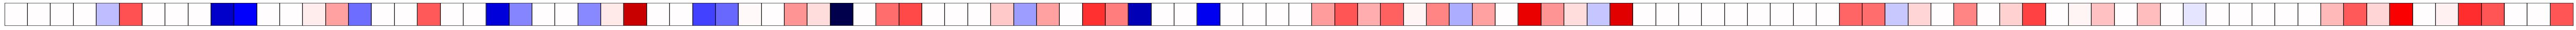

28 has_back_color::yellow 0.1744079887866974
71 has_belly_color::brown 0.15160872042179108
67 has_nape_color::yellow 0.14218255877494812
105 has_crown_color::grey 0.1271357536315918
108 has_crown_color::white 0.10119763761758804
48 has_throat_color::black 0.0996900349855423
89 has_tail_pattern::multi-colored 0.09108465909957886
40 has_breast_color::brown 0.0884968638420105
6 has_wing_color::grey 0.0841670036315918
112 has_wing_pattern::multi-colored 0.08283081650733948
109 has_wing_pattern::solid 0.08224848657846451
59 has_forehead_color::white 0.08200933784246445
103 has_crown_color::blue 0.08028233051300049
19 has_underparts_color::yellow 0.07943475991487503
61 has_under_tail_color::grey 0.07610122859477997
81 has_size::very_small_(3_-_5_in) 0.07491479814052582
82 has_shape::duck-like 0.07047863304615021
39 has_head_pattern::plain 0.06994735449552536
49 has_throat_color::white 0.061844807118177414
63 has_under_tail_color::white 0.05989506468176842
86 has_back_pattern::multi-colored 0

In [22]:
vector = True
show_concept_no = False

if vector:
    grad_plot = image_gradient
    plt.figure(figsize=(112, 1))
else:
    grad_plot = image_gradient.reshape(8, 14)
    plt.figure(figsize=(14,8))


if show_concept_no:
    current_index = 0
    for y in range(grad_plot.size(0)):
        for x in range(grad_plot.size(1)):
            plt.text(x, y, f'{current_index + 1}',
                     horizontalalignment='center',
                     verticalalignment='center',
                     )
            current_index += 1

        
sorted, indexes = image_gradient[0].sort(descending=True)


# center 0 for min and max values on figure
if abs(sorted[0].item()) > abs(sorted[-1].item()):
    vmin = 0 - abs(sorted[0].item())
    vmax = abs(sorted[0].item())
else:
    vmin = 0 - abs(sorted[-1].item())
    vmax = abs(sorted[-1].item())

if vector:
    plt.imshow(image_gradient.cpu(), cmap='seismic', vmin=vmin, vmax=vmax)
else:
    plt.imshow(image_gradient.cpu().reshape(8, 14), cmap='seismic', vmin=vmin, vmax=vmax)
    
plt.xticks([])
plt.yticks([])
plt.grid(which='minor', axis='x', linewidth=2, color='b')
for concent_num in range(N_CONCEPT):
    plt.axvline(x=concent_num-0.5, color='black')
plt.show()

plt.close()

# print concept as string in order of gradient from highest to lowest
for relevance, idx in zip(sorted, indexes):
    print(idx.item() + 1, concept_index_to_string(idx.item()), relevance.item())

## Compute concept contribution proportion

In [23]:
ins = inputs['grads'][0]
grads = gradients['grads'][0]



# Calculate the proportions per input concept

ratios = []
for in_, grad_ in zip(ins, grads):
    ratios.append(grad_ / in_)
    
#print(ratios)

balaced_ratios = []
for idx, i in enumerate(ratios):
    balaced_ratios.append((idx, i / sum(ratios)))

print("Total ratios:", sum([i[1] for i in balaced_ratios]))

balaced_ratios.sort(key=lambda x: x[1].item(), reverse=True)

for ratio in balaced_ratios:
    print(f"{ratio[0]+1}: {concept_index_to_string(ratio[0])} ({round(float(ratio[1]*100), 2)}%)")

Total ratios: tensor(1.0000, device='cuda:0', grad_fn=<AddBackward0>)
37: has_upper_tail_color::buff (6.47%)
50: has_throat_color::buff (4.44%)
10: has_wing_color::buff (4.44%)
11: has_upperparts_color::brown (4.32%)
53: has_bill_length::shorter_than_head (3.61%)
22: has_underparts_color::buff (3.61%)
31: has_back_color::buff (3.43%)
71: has_belly_color::brown (2.63%)
23: has_breast_pattern::solid (2.6%)
32: has_tail_shape::notched_tail (2.58%)
105: has_crown_color::grey (2.56%)
28: has_back_color::yellow (2.42%)
6: has_wing_color::grey (2.34%)
26: has_back_color::brown (2.31%)
112: has_wing_pattern::multi-colored (2.28%)
48: has_throat_color::black (2.19%)
67: has_nape_color::yellow (2.15%)
16: has_upperparts_color::buff (2.11%)
81: has_size::very_small_(3_-_5_in) (2.04%)
61: has_under_tail_color::grey (2.03%)
49: has_throat_color::white (2.02%)
89: has_tail_pattern::multi-colored (1.93%)
109: has_wing_pattern::solid (1.91%)
35: has_upper_tail_color::black (1.86%)
58: has_forehead_col

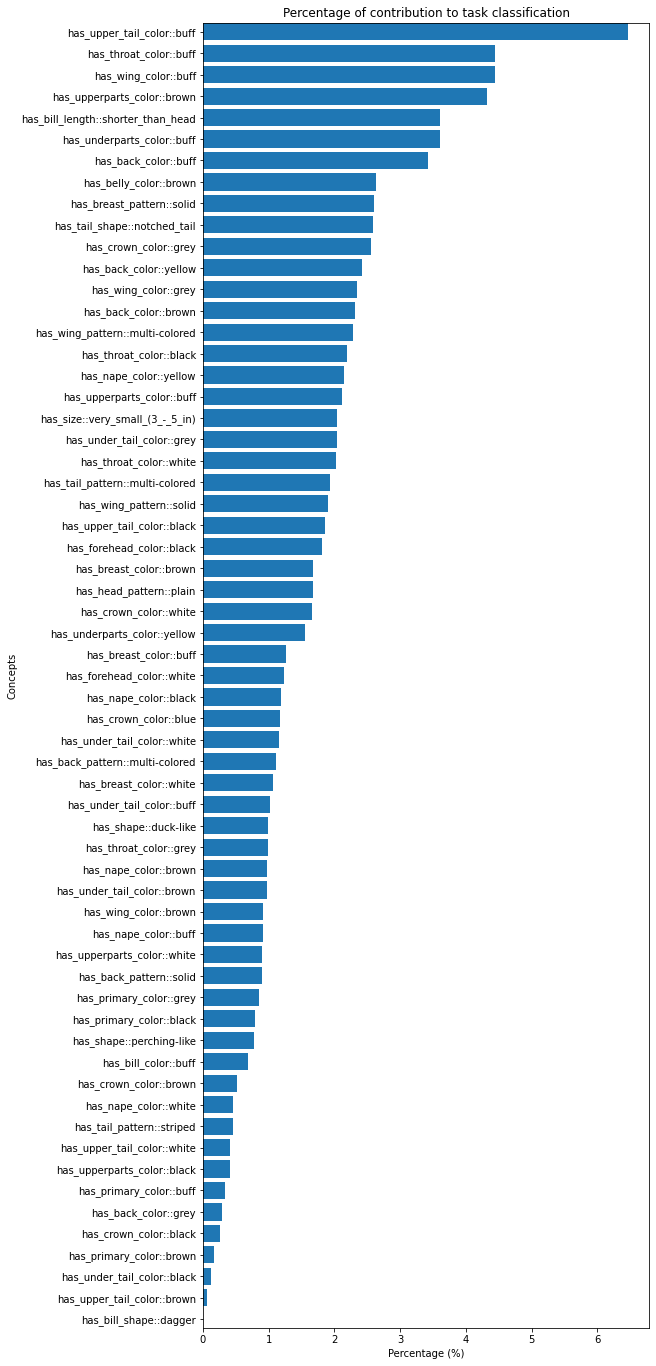

In [24]:
percentages = [round(float(x[1]*100), 3) for x in balaced_ratios]
labels = [concept_index_to_string(x[0]) for x in balaced_ratios]

#print(percentages)
#print(labels)

keep_percentages = []
zero_keep = 2
for i in percentages:
    if i > 0:
        keep_percentages.append(i)
    elif zero_keep > 1:
        keep_percentages.append(i)
        zero_keep -= 1
        
keep_labels = labels[:len(keep_percentages)]



y_pos = np.arange(len(keep_labels))

fig = plt.subplots(figsize = (8, 24)) 

plt.barh(y_pos, keep_percentages)
plt.ylabel("Concepts")
plt.xlabel("Percentage (%)")
plt.title("Percentage of contribution to task classification")

plt.yticks(y_pos, keep_labels)

plt.gca().invert_yaxis()
plt.margins(y=0)

plt.show()